# Recurrent Neural Networks

Recurrent layer output for one sample:

$\mathbf{y}_{(t)}=\phi({\mathbf{W}_x}^T\cdot\mathbf{x}_{(t)}+{\mathbf{W}_y}^T\cdot\mathbf{y}_{(t-1)}+\mathbf{b})$

And for all samples:

$\begin{split}
\mathbf{Y}_{(t)}&=\phi(\mathbf{X}_{(t)}\cdot\mathbf{W}_{x}+\mathbf{Y}_{(t-1)}\cdot\mathbf{W}_{y}+\mathbf{b})\\
&=\phi(\left[\mathbf{X}_{(t)}\phantom{X}\mathbf{Y}_{(t-1)}\right]\cdot\mathbf{W}+\mathbf{b})
\end{split}$


with $\mathbf{W}=\left[\begin{array}{c}
\mathbf{W}_x\\
\mathbf{W}_y
\end{array}\right]$

- $\mathbf{Y}_{(t)}$ - matrix $m \times n_{\text{neurons}}$
- $\mathbf{X}_{(t)}$ - matrix $m \times n_{\text{inputs}}$
- $\mathbf{W}_x$ - matrix $n_{\text{inputs}} \times n_{\text{neurons}}$
- $\mathbf{W}_y$ - matrix $n_{\text{neurons}} \times n_{\text{neurons}}$
- $\mathbf{b}$ - vector of size $n_{\text{neurons}}$

## Basic RNN with TensorFlow

In [44]:
def reset_graph():
    tf.reset_default_graph()

In [45]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [20]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, (None, n_inputs))
X1 = tf.placeholder(tf.float32, (None, n_inputs))

Wx = tf.Variable(tf.random_normal(shape=(n_inputs, n_neurons)), dtype=tf.float32)
Wy = tf.Variable(tf.random_normal(shape=(n_neurons, n_neurons)), dtype=tf.float32)
b = tf.Variable(tf.zeros((1, n_neurons)), dtype=tf.float32)

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [21]:
import numpy as np
                    # sample 0  sample 1   sample 2   sample 3
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])  # t=0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])  # t=1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [24]:
print(Y0_val)

[[ 0.9998845   0.9985211   0.9807717   0.42409754  0.12938699]
 [ 1.          1.          1.         -0.4425541   0.71254337]
 [ 1.          1.          1.         -0.88610226  0.9294788 ]
 [ 0.8929707  -0.2217794   0.9999999  -0.9999985   0.86951333]]


In [23]:
print(Y1_val)

[[ 1.          1.          1.         -0.98594075  0.7372455 ]
 [-0.96119756  0.82696277  0.98419595 -0.7695875  -0.92860484]
 [ 1.          1.          1.         -0.999511   -0.47752377]
 [ 0.9999276   0.9990764   0.99999905 -0.99869365 -0.98094934]]


## ``static_rnn()``

In [27]:
reset_graph()

X0 = tf.placeholder(tf.float32, (None, n_inputs))
X1 = tf.placeholder(tf.float32, (None, n_inputs))

basic_cell = tf.keras.layers.SimpleRNNCell(units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)
Y0, Y1 = output_seqs

init = tf.global_variables_initializer()

In [28]:
with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [29]:
print(Y0_val)

[[ 0.7775582  -0.9588775   0.583342   -0.8656785   0.06241423]
 [ 0.9999786  -0.9997971   0.9766191  -0.99851596  0.85624963]
 [ 1.         -0.999999    0.99893725 -0.9999847   0.9865007 ]
 [ 0.99998623  0.9961089   0.9988884   0.89188784 -0.7275337 ]]


In [30]:
print(Y1_val)

[[ 1.         -0.99998355  0.9984809  -0.99999183  0.97817904]
 [-0.6203504  -0.33362556  0.00255545 -0.5979532  -0.95510876]
 [ 0.9999995  -0.9990898   0.9862038  -0.99920183  0.40492308]
 [ 0.9997139  -0.18447568  0.9781278  -0.97400355  0.9001233 ]]


Or the much better way to define X:

In [36]:
reset_graph()

n_steps = 2

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))
basic_cell = tf.keras.layers.SimpleRNNCell(units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

init = tf.global_variables_initializer()

In [37]:
X_batch = np.array([
      # t = 0      t = 1
    [[0, 1, 2], [9, 8, 7]],  # sample 0
    [[3, 4, 5], [0, 0, 0]],  # sample 1
    [[6, 7, 8], [6, 5, 4]],  # sample 2
    [[9, 0, 1], [3, 2, 1]]   # sample 3
])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [38]:
print(outputs_val)

[[[ 0.78644925  0.23237634  0.7817101  -0.5340793   0.88090867]
  [ 0.85650396  0.99997795  0.99998057  0.99992603  0.9999137 ]]

 [[ 0.9377855   0.9444776   0.99797213  0.6387327   0.9977533 ]
  [-0.08335785  0.90263355  0.24798323  0.8638597  -0.39955902]]

 [[ 0.9829014   0.99738544  0.99998325  0.9709079   0.99996   ]
  [ 0.1397619   0.9996409   0.99957067  0.9998518   0.9657296 ]]

 [[-0.998372    0.9979464  -0.69987684  0.99930674 -0.9833075 ]
  [-0.95189613  0.04853842  0.935623    0.97434515 -0.13885137]]]


## ``dynamic_rnn()``

In [39]:
reset_graph()

X = tf.placeholder(tf.float32, (None, n_steps, n_inputs))
basic_cell = tf.keras.layers.SimpleRNNCell(units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

In [41]:
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [42]:
print(outputs_val)

[[[-0.03482872 -0.2341569  -0.3819376  -0.5550543   0.95308256]
  [-0.6414222   0.98714066  0.99987876 -1.          1.        ]]

 [[-0.4705129   0.6107307   0.6675099  -0.9990505   0.999997  ]
  [ 0.25642464 -0.48041275  0.556726   -0.8514268   0.68712175]]

 [[-0.75591516  0.9300493   0.9650586  -0.9999984   1.        ]
  [-0.6992848   0.9307176   0.9977707  -0.9999994   0.99999994]]

 [[ 0.650494    0.99166745  0.9998903  -0.9981866   0.9995775 ]
  [ 0.38949347  0.890519    0.95712805 -0.9987376   0.9997413 ]]]


### Input sequences with different length

In [44]:
reset_graph()

seq_length = tf.placeholder(tf.int32, (None))

X = tf.placeholder(tf.float32, (None, n_steps, n_inputs))
basic_cell = tf.keras.layers.SimpleRNNCell(units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32, sequence_length=seq_length)

init = tf.global_variables_initializer()

In [48]:
X_batch = np.array([
      # t = 0      t = 1
    [[0, 1, 2], [9, 8, 7]],  # sample 0
    [[3, 4, 5], [0, 0, 0]],  # sample 1 with vector of zeroes (it means on the t = 1 there is no input)
    [[6, 7, 8], [6, 5, 4]],  # sample 2
    [[9, 0, 1], [3, 2, 1]]   # sample 3
])

seq_length_batch = np.array([2, 1, 2, 2])

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [49]:
print(outputs_val)

[[[-0.07281392 -0.810872   -0.07239084 -0.8578082   0.7530198 ]
  [-0.833189   -0.9931133   0.99999964  0.9987863   0.99905145]]

 [[-0.39503723 -0.9891931   0.97979647 -0.6916948   0.99109   ]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.6425862  -0.9994348   0.9998199  -0.39474493  0.9997158 ]
  [-0.23475975 -0.9548405   0.99985254  0.9993263   0.98874575]]

 [[-0.17676206  0.9956495   0.99999535  0.9999986   0.9998489 ]
  [ 0.03924279 -0.05626582  0.63885915  0.9605177   0.93835074]]]


In [50]:
print(states_val)

[[-0.833189   -0.9931133   0.99999964  0.9987863   0.99905145]
 [-0.39503723 -0.9891931   0.97979647 -0.6916948   0.99109   ]
 [-0.23475975 -0.9548405   0.99985254  0.9993263   0.98874575]
 [ 0.03924279 -0.05626582  0.63885915  0.9605177   0.93835074]]


## Training RNN

In [90]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [91]:
X_train.dtype

dtype('uint8')

In [92]:
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [93]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [94]:
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [46]:
def get_train_test_mnist():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.astype(np.float32) / 255.0
    X_test = X_test.astype(np.float32) / 255.0
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    return X_train, X_test, y_train, y_test

In [47]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [6]:
reset_graph()

n_inputs = 28
n_steps = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

with tf.name_scope("rnn"):
    X = tf.placeholder(tf.float32, (None, n_steps, n_inputs))
    y = tf.placeholder(tf.int32, (None))

    basic_cell = tf.keras.layers.SimpleRNNCell(units=n_neurons)
    #basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

    logits = tf.layers.dense(states, n_outputs)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

init = tf.global_variables_initializer()

In [96]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch {}: Training acccuracy = {:.3f}\tTest accuracy = {:.3f}".format(epoch, acc_train, acc_test))

Epoch 0: Training acccuracy = 0.933	Test accuracy = 0.913
Epoch 1: Training acccuracy = 0.933	Test accuracy = 0.952
Epoch 2: Training acccuracy = 0.920	Test accuracy = 0.951
Epoch 3: Training acccuracy = 0.960	Test accuracy = 0.960
Epoch 4: Training acccuracy = 0.973	Test accuracy = 0.970
Epoch 5: Training acccuracy = 0.980	Test accuracy = 0.968
Epoch 6: Training acccuracy = 0.980	Test accuracy = 0.966
Epoch 7: Training acccuracy = 0.980	Test accuracy = 0.970
Epoch 8: Training acccuracy = 0.987	Test accuracy = 0.970
Epoch 9: Training acccuracy = 0.987	Test accuracy = 0.978
Epoch 10: Training acccuracy = 1.000	Test accuracy = 0.973
Epoch 11: Training acccuracy = 0.973	Test accuracy = 0.971
Epoch 12: Training acccuracy = 0.987	Test accuracy = 0.966
Epoch 13: Training acccuracy = 0.980	Test accuracy = 0.967
Epoch 14: Training acccuracy = 0.960	Test accuracy = 0.971
Epoch 15: Training acccuracy = 0.980	Test accuracy = 0.974
Epoch 16: Training acccuracy = 0.987	Test accuracy = 0.967
Epoch 1

## Time Series

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
t_min = 0
t_max = 30
resoltion = 0.1

In [3]:
def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(5 * t)

In [4]:
def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resoltion)
    Ts = t0 + np.arange(0., n_steps + 1) * resoltion
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

In [27]:
a = np.random.rand(2, 1)

In [28]:
a + b

array([[0.96413461, 1.96413461, 2.96413461, 3.96413461, 4.96413461,
        5.96413461, 6.96413461, 7.96413461, 8.96413461, 9.96413461],
       [0.22552663, 1.22552663, 2.22552663, 3.22552663, 4.22552663,
        5.22552663, 6.22552663, 7.22552663, 8.22552663, 9.22552663]])

In [24]:
X_batch, y_batch = next_batch(2, 20)

In [27]:
X_batch[0]

array([[-2.64717691],
       [-2.36668909],
       [-2.47363871],
       [-3.02936   ],
       [-3.97570177],
       [-5.14835602],
       [-6.31627456],
       [-7.23753267],
       [-7.71797079],
       [-7.65826428],
       [-7.07790292],
       [-6.11021431],
       [-4.96965296],
       [-3.89936633],
       [-3.11187609],
       [-2.73739733],
       [-2.79244696],
       [-3.17642338],
       [-3.69698999],
       [-4.1180414 ]])

In [28]:
y_batch[0]

array([[-2.36668909],
       [-2.47363871],
       [-3.02936   ],
       [-3.97570177],
       [-5.14835602],
       [-6.31627456],
       [-7.23753267],
       [-7.71797079],
       [-7.65826428],
       [-7.07790292],
       [-6.11021431],
       [-4.96965296],
       [-3.89936633],
       [-3.11187609],
       [-2.73739733],
       [-2.79244696],
       [-3.17642338],
       [-3.69698999],
       [-4.1180414 ],
       [-4.21850083]])

In [32]:
n_steps = 20

t = np.linspace(t_min, t_max, int((t_max - t_min) / resoltion))
t_batch = np.linspace(12.2, 12.2 + (n_steps + 1) * resoltion, n_steps + 1)

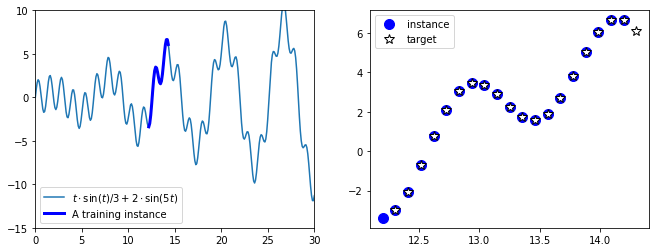

In [33]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(t, time_series(t), label=r"$t\cdot\sin(t) / 3 + 2\cdot\sin(5t)$")
plt.plot(t_batch, time_series(t_batch), 'b-', linewidth=3, label="A training instance")
plt.axis([0, 30, -15, 10])
plt.legend(loc="lower left")

plt.subplot(122)
plt.plot(t_batch[:-1], time_series(t_batch[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_batch[1:], time_series(t_batch[1:]), "w*", markersize=10, markeredgecolor="k", label="target")
plt.legend(loc="upper left");

In [9]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1
learning_rate = 0.001

X = tf.placeholder(tf.float32, shape=(None, n_steps, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, n_steps, n_outputs), name="y")

# [!] but in this case we'll get 100 outputs on each step. We need only 1 output on each step.

#cell = tf.keras.layers.SimpleRNNCell(units=n_neurons, activation=tf.nn.relu)
# outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

with tf.name_scope("rnn"):

#  It doesn't work with tf.nn.dynamic_rnn
#     cell = tf.contrib.rnn.OutputProjectionWrapper(tf.keras.layers.SimpleRNNCell(units=n_neurons, 
#                                                                                 activation=tf.nn.relu), 
#                                                   output_size=n_outputs)
    cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, 
                                                                              activation=tf.nn.relu), 
                                                  output_size=n_outputs)
    outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.square(outputs - y), name="loss")

with tf.name_scope("training"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

saver = tf.train.Saver()
init = tf.global_variables_initializer()
file_writer = tf.summary.FileWriter('../tf_logs/RNN_graph', tf.get_default_graph())

In [34]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print("{:>4}\tMSE: {:.6f}".format(iteration, mse))
    save_path = saver.save(sess, "../models/RNN_model/RNN_model.ckpt")

   0	MSE: 10.579765
 100	MSE: 0.412781
 200	MSE: 0.128550
 300	MSE: 0.087552
 400	MSE: 0.057792
 500	MSE: 0.049437
 600	MSE: 0.045760
 700	MSE: 0.062534
 800	MSE: 0.053259
 900	MSE: 0.040020
1000	MSE: 0.044933
1100	MSE: 0.041668
1200	MSE: 0.045053
1300	MSE: 0.047864
1400	MSE: 0.049626


In [38]:
X_new = time_series(np.array(t_batch[:-1].reshape(-1, n_steps, n_inputs)))
X_new

array([[[-3.38903462],
        [-2.99062806],
        [-2.05341138],
        [-0.72228309],
        [ 0.75538291],
        [ 2.09516406],
        [ 3.05094764],
        [ 3.47993654],
        [ 3.37980751],
        [ 2.88802793],
        [ 2.24353023],
        [ 1.7210823 ],
        [ 1.55604639],
        [ 1.87980783],
        [ 2.68328027],
        [ 3.81833127],
        [ 5.03675731],
        [ 6.05632222],
        [ 6.63608254],
        [ 6.64072041]]])

In [39]:
with tf.Session() as sess:
    saver.restore(sess, save_path)
    X_new = time_series(np.array(t_batch[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = outputs.eval(feed_dict={X: X_new})
y_pred

INFO:tensorflow:Restoring parameters from ../models/RNN_model/RNN_model.ckpt


array([[[-3.418631 ],
        [-2.5242887],
        [-1.116062 ],
        [ 0.7442514],
        [ 2.1620588],
        [ 3.014197 ],
        [ 3.461007 ],
        [ 3.3199575],
        [ 2.8357456],
        [ 2.1321704],
        [ 1.6427138],
        [ 1.547963 ],
        [ 1.8917968],
        [ 2.708661 ],
        [ 3.8145556],
        [ 5.0564547],
        [ 6.1031137],
        [ 6.6533237],
        [ 6.6001925],
        [ 6.002033 ]]], dtype=float32)

In [21]:
def plot_results(X_new, y_pred):
    plt.title("Testing the model", fontsize=14)
    plt.plot(t_batch[:-1], X_new.ravel(), 'bo', ms=10, label="Sample")
    plt.plot(t_batch[1:], time_series(t_batch[1:]), 'w*', ms=10, mec="k", label="Target")
    plt.plot(t_batch[1:], y_pred.ravel(), 'ro', ms=5, label="Prediction")
    plt.xlabel("Time")
    plt.legend(loc="upper left");

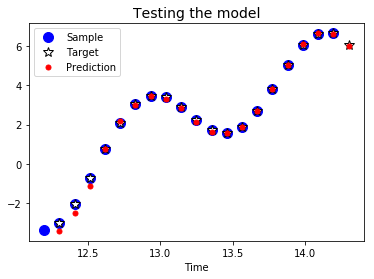

In [61]:
plot_results(X_new, y_pred)

**The same as above but without ``OutputProjectionWrapper``**

In [62]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

learning_rate = 0.001

X = tf.placeholder(tf.float32, shape=(None, n_steps, n_inputs))
y = tf.placeholder(tf.float32, shape=(None, n_steps, n_outputs))

with tf.name_scope("rnn"):
    cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
    rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    stacked_rnn_outputs = tf.reshape(rnn_outputs, shape=(-1, n_neurons))
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, shape=(-1, n_steps, n_outputs))

with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.square(outputs - y))

with tf.name_scope("training"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

saver = tf.train.Saver()
init = tf.global_variables_initializer()
file_writer = tf.summary.FileWriter("../tf_logs/RNN_dense_model", tf.get_default_graph())

In [63]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print("{:>4}\tMSE: {:.6f}".format(iteration, mse))
    save_path = saver.save(sess, "../models/RNN_dense_model/RNN_dense_model.ckpt")

   0	MSE: 19.119144
 100	MSE: 0.456892
 200	MSE: 0.246259
 300	MSE: 0.089165
 400	MSE: 0.073335
 500	MSE: 0.052384
 600	MSE: 0.050028
 700	MSE: 0.062669
 800	MSE: 0.059116
 900	MSE: 0.046589
1000	MSE: 0.050910
1100	MSE: 0.039381
1200	MSE: 0.040723
1300	MSE: 0.042398
1400	MSE: 0.051509


In [64]:
with tf.Session() as sess:
    saver.restore(sess, save_path)
    X_new = time_series(np.array(t_batch[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = outputs.eval(feed_dict={X: X_new})
y_pred

INFO:tensorflow:Restoring parameters from ../models/RNN_dense_model/RNN_dense_model.ckpt


array([[[-3.4043775],
        [-2.4661093],
        [-1.1606103],
        [ 0.5833237],
        [ 2.102199 ],
        [ 3.0753608],
        [ 3.503358 ],
        [ 3.3203838],
        [ 2.7397053],
        [ 2.1419108],
        [ 1.7022904],
        [ 1.5795189],
        [ 1.8956374],
        [ 2.6968946],
        [ 3.8882375],
        [ 5.170391 ],
        [ 6.1858897],
        [ 6.7004714],
        [ 6.6157036],
        [ 5.9950366]]], dtype=float32)

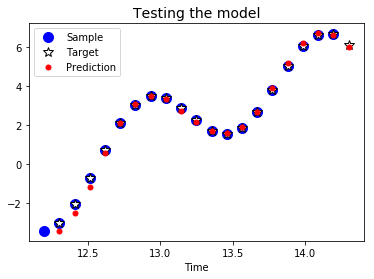

In [65]:
plot_results(X_new, y_pred)

## Deep RNN

In [5]:
import numpy as np

In [4]:
reset_graph()

n_steps = 20
n_inputs = 2
n_neurons = 100
n_layers = 3

X = tf.placeholder(dtype=tf.float32, shape=(None, n_steps, n_inputs), name="X")

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu) for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

In [6]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [8]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [9]:
outputs_val.shape

(2, 20, 100)

## Distributing a Depp RNN across multiple devices

In [10]:
class DeviceCellWrapper(tf.contrib.rnn.BasicRNNCell):
    def __init__(self, device, cell):
        self._cell = cell
        self._device = device
    
    @property
    def state_size(self):
        return self._cell.state_size
    
    @property
    def output_size(self):
        return self._cell.output_size
    
    def __call__(self, inputs, state, scope=None):
        with tf.device(self._device):
            return self._cell(inputs, state, scope)

In [11]:
reset_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=(None, n_steps, n_inputs), name="X")

devices = ["/gpu:0", "/gpu:1", "/gpu:2"]

cells = [DeviceCellWrapper(dev, tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)) 
         for dev in devices]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

## Dropout

In [16]:
reset_graph()

n_inputs = 1
n_steps = 20
n_neurons = 100
n_layers = 3
n_outputs = 1

learning_rate = 0.001

X = tf.placeholder(tf.float32, shape=(None, n_steps, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, n_steps, n_outputs), name="y")
keep_prob = tf.placeholder_with_default(1.0, shape=())

with tf.name_scope("DRNN"):
    cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons) for layer in range(n_layers)]

    # dropout after each layer
    cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob) for cell in cells]
    multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
    rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
    rnn_outputs_stacked = tf.reshape(rnn_outputs, shape=(-1, n_neurons))
    stacked_outputs = tf.layers.dense(rnn_outputs_stacked, n_outputs)
    outputs = tf.reshape(stacked_outputs, shape=(-1, n_steps, n_outputs))
    
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.square(outputs - y), name="loss")
    
with tf.name_scope("training"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [18]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss], feed_dict={X: X_batch, y: y_batch, keep_prob: train_keep_prob})
        if iteration % 100 == 0:
            print("{:>4}\t MSE: {:.6f}".format(iteration, mse))
    save_path = saver.save(sess, "../tf_logs/DRNN_Dropout/DRNN_Dropout.ckpt")

   0	 MSE: 17.907507
 100	 MSE: 3.986404
 200	 MSE: 4.240381
 300	 MSE: 3.237766
 400	 MSE: 2.602382
 500	 MSE: 3.226249
 600	 MSE: 2.719673
 700	 MSE: 3.281750
 800	 MSE: 2.425601
 900	 MSE: 2.920539
1000	 MSE: 2.369786
1100	 MSE: 3.197427
1200	 MSE: 2.260556
1300	 MSE: 2.157855
1400	 MSE: 2.022089


In [19]:
n_steps = 20

t = np.linspace(t_min, t_max, int((t_max - t_min) / resoltion))
t_batch = np.linspace(12.2, 12.2 + (n_steps + 1) * resoltion, n_steps + 1)

In [20]:
with tf.Session() as sess:
    saver.restore(sess, save_path)
    X_new = time_series(np.array(t_batch[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = outputs.eval(feed_dict={X: X_new})
y_pred

INFO:tensorflow:Restoring parameters from ../tf_logs/DRNN_Dropout/DRNN_Dropout.ckpt


array([[[-2.1434672 ],
        [-1.1598965 ],
        [-0.63197285],
        [ 0.0643439 ],
        [ 0.24737701],
        [ 1.2513586 ],
        [ 0.8129308 ],
        [ 0.94653857],
        [ 0.35581866],
        [ 0.4564511 ],
        [ 0.18775132],
        [-0.04137591],
        [ 0.25476548],
        [ 1.2167852 ],
        [ 2.2852168 ],
        [ 3.1037507 ],
        [ 3.7475863 ],
        [ 3.7839715 ],
        [ 3.4720988 ],
        [ 2.8120358 ]]], dtype=float32)

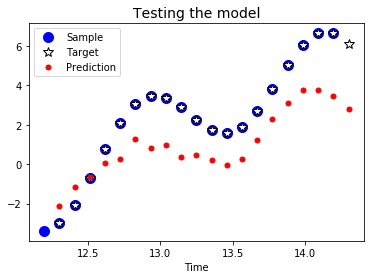

In [24]:
plot_results(X_new, y_pred)

# LSTM

- $\mathbf{c}_{(t)}$ - long-term memory
- $\mathbf{h}_{(t)}$ - short-term memory

Gates:

- $\mathbf{i}_{(t)}$ - input gate
- $\mathbf{f}_{(t)}$ - forget gate
- $\mathbf{o}_{(t)}$ - output gate
- $\mathbf{g}_{(t)}$ - general gate


Outputs:
- $\mathbf{i}_{(t)} = \sigma\left({\mathbf{W}_{xi}}^T\cdot\mathbf{x}_{(t)} 
+ {\mathbf{W}_{hi}}^T\cdot\mathbf{h}_{(t-1)} + \mathbf{b}_i\right)$
- $\mathbf{f}_{(t)} = \sigma\left({\mathbf{W}_{xf}}^T\cdot\mathbf{x}_{(t)} 
+ {\mathbf{W}_{hf}}^T\cdot\mathbf{h}_{(t-1)} + \mathbf{b}_f\right)$
- $\mathbf{o}_{(t)} = \sigma\left({\mathbf{W}_{xo}}^T\cdot\mathbf{x}_{(t)} 
+ {\mathbf{W}_{ho}}^T\cdot\mathbf{h}_{(t-1)} + \mathbf{b}_o\right)$
- $\mathbf{g}_{(t)} = \text{tanh}\left({\mathbf{W}_{xg}}^T\cdot\mathbf{x}_{(t)} 
+ {\mathbf{W}_{hg}}^T\cdot\mathbf{h}_{(t-1)} + \mathbf{b}_g\right)$
- $\mathbf{c}_{(t)} = \mathbf{f}_{(t)}\otimes\mathbf{c}_{(t-1)} + \mathbf{i}_{(t)}\otimes\mathbf{g}_{(t)}$
- $\mathbf{y}_{(t)} = \mathbf{h}_{(t)} = \mathbf{o}_{(t)}\otimes\text{tanh}\left(\mathbf{c}_{(t)}\right)$

In [48]:
X_train, X_test, y_train, y_test = get_train_test_mnist()

In [50]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [56]:
reset_graph()

n_inputs = 28
n_steps = 28
n_neurons = 150
n_layers = 3
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(dtype=tf.float32, shape=(None, n_steps, n_inputs), name="X")
y = tf.placeholder(dtype=tf.int32, shape=(None))

lstm_cells = [tf.nn.rnn_cell.LSTMCell(num_units=n_neurons) for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [57]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>))

In [58]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>

In [61]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test[:150], y: y_test[:150]})
        print("Epoch {:>2}\tTraining set accuracy: {:.5f}\tTest set accuracy: {:.5f}".format(epoch, 
                                                                                             acc_train, 
                                                                                             acc_test))

Epoch  0	Training set accuracy: 0.97333	Test set accuracy: 0.98000
Epoch  1	Training set accuracy: 0.97333	Test set accuracy: 1.00000
Epoch  2	Training set accuracy: 0.99333	Test set accuracy: 1.00000
Epoch  3	Training set accuracy: 1.00000	Test set accuracy: 1.00000
Epoch  4	Training set accuracy: 1.00000	Test set accuracy: 1.00000
Epoch  5	Training set accuracy: 1.00000	Test set accuracy: 1.00000
Epoch  6	Training set accuracy: 1.00000	Test set accuracy: 1.00000
Epoch  7	Training set accuracy: 0.99333	Test set accuracy: 0.99333
Epoch  8	Training set accuracy: 0.99333	Test set accuracy: 0.99333
Epoch  9	Training set accuracy: 1.00000	Test set accuracy: 0.99333
